# 5. Détection des piscines à l'aide du modèle `fedpool`

In [66]:
import os
import torch
import pandas as pd
from datetime import datetime

On charge le modèle avec les poids du modèle entraîné (qui est en local)

In [2]:
model = torch.hub.load('../yolov5', 'custom', path='../fedpool_model/weights/best.pt', source='local')

YOLOv5  v7.0-315-g892e8a82 Python-3.12.2 torch-2.2.2 CUDA:0 (Quadro M1200, 4096MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


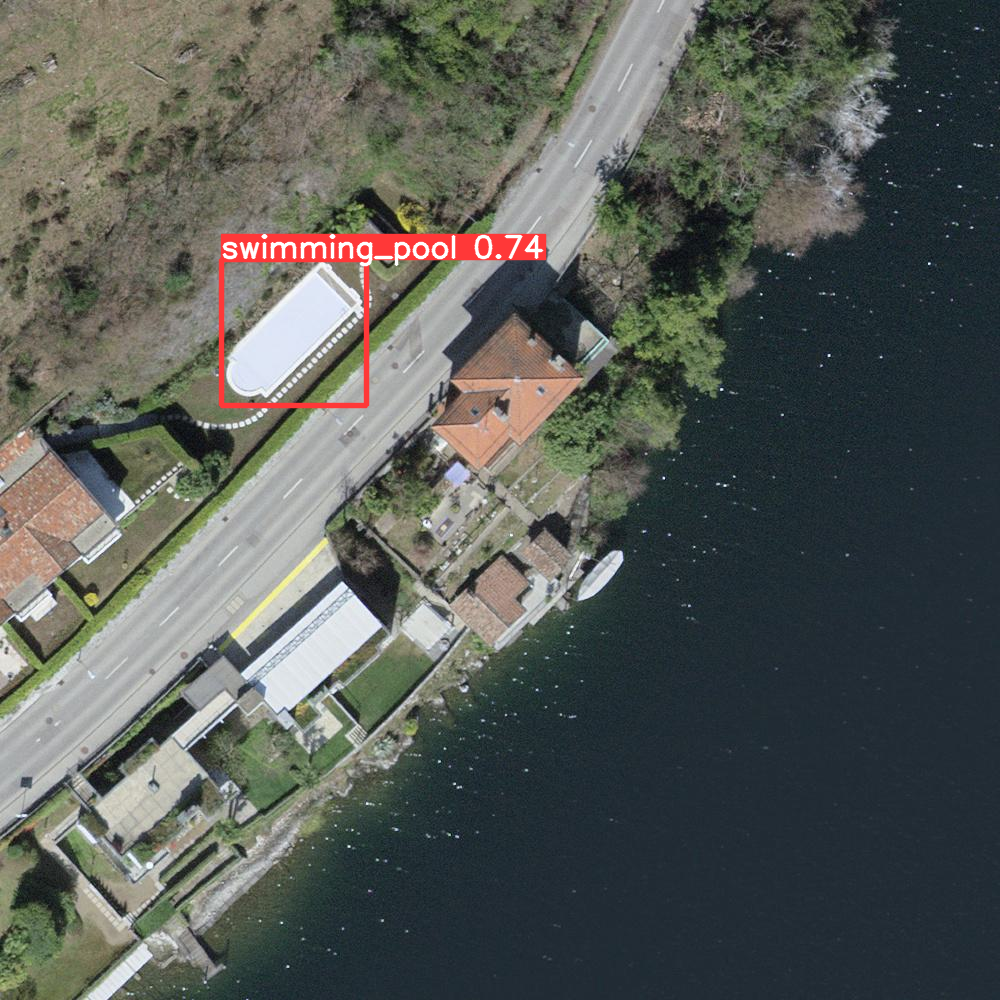

In [3]:
# Test avec image inédite
results = model('../data/img_reduites/1000/jpg/27152-10873.jpg')
results.show()

### Application à toutes les images téléchargées

Préparation du df final et des chemins d'images

In [72]:
# Préparer les accès aux images
img_path = '../data/img_reduites/1000/jpg/'
image_paths = [os.path.join(img_path, fname) for fname in os.listdir(img_path)]

pools_bbox = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax'])

Dans ce cas de figure, on extrait toutes les détections. Il serait possible de jouer avec la valeur de confiance pour mettre un seuil et ne garder que les détections supérieures à ce seuil.

In [73]:
# Itérer par groupe d'images
for i in range(len(image_paths)):
    batch_paths = image_paths[i]
    batch_results = model(batch_paths)

    if i % 1000 == 0:
        print(f"{i} / {len(image_paths)} | {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}")

    # Pour chaque résultat, si détection, extraire les coordonnées (CH) de la bbox
    for i in range(len(batch_results)):
        df = batch_results.pandas().xyxy[i]
        if df.shape[0] > 0:
            fname = batch_results.files[i]
            x_coords = fname.strip('.jpg').split("-")[0]
            y_coords = fname.strip('.jpg').split("-")[1]

            for row in df.itertuples(index=False, name='Pandas'):
                # if row.confidence > seuil_de_confiance:
                xmin = x_coords + '{:02d}'.format(round(row.xmin / 10))
                # si xmax touche le bord (1000), il faut augmenter la coorde de base de 1 et ajouter 00 sinon 8 chiffres dans la coord
                xmax = x_coords + '{:02d}'.format(round(row.xmax / 10)) if round(row.xmax / 10) < 100 else str(int(x_coords) + 1) + '00'
                # Inversion de ymin et ymax comme le format va de haut en bas et les coords l'inverse
                ymin = y_coords + '{:02d}'.format(100 - round(row.ymax / 10))
                # Si ymin part du bord, il faut ajouter 1 à la coord de base
                ymax = y_coords + '{:02d}'.format(100 - round(row.ymin / 10)) if 100 - round(row.ymin / 10) < 100 else str(int(y_coords) + 1) + '00'
                
                pool_bbox = pd.DataFrame({'xmin': [xmin], 'ymin': [ymin], 'xmax': [xmax], 'ymax': [ymax]})

                pools_bbox = pd.concat([pools_bbox, pool_bbox], ignore_index=True)   
    

0 / 55200 | 2024-05-31 08:52:40
1000 / 55200 | 2024-05-31 08:54:45
2000 / 55200 | 2024-05-31 08:57:08
3000 / 55200 | 2024-05-31 08:59:44
4000 / 55200 | 2024-05-31 09:02:30
5000 / 55200 | 2024-05-31 09:05:45
6000 / 55200 | 2024-05-31 09:08:00
7000 / 55200 | 2024-05-31 09:10:17
8000 / 55200 | 2024-05-31 09:12:34
9000 / 55200 | 2024-05-31 09:14:54
10000 / 55200 | 2024-05-31 09:17:18
11000 / 55200 | 2024-05-31 09:19:47
12000 / 55200 | 2024-05-31 09:22:11
13000 / 55200 | 2024-05-31 09:24:41
14000 / 55200 | 2024-05-31 09:27:12
15000 / 55200 | 2024-05-31 09:29:43
16000 / 55200 | 2024-05-31 09:32:10
17000 / 55200 | 2024-05-31 09:34:37
18000 / 55200 | 2024-05-31 09:37:02
19000 / 55200 | 2024-05-31 09:39:27
20000 / 55200 | 2024-05-31 09:41:51
21000 / 55200 | 2024-05-31 09:44:14
22000 / 55200 | 2024-05-31 09:46:39
23000 / 55200 | 2024-05-31 09:49:05
24000 / 55200 | 2024-05-31 09:51:34
25000 / 55200 | 2024-05-31 09:53:59
26000 / 55200 | 2024-05-31 09:56:23
27000 / 55200 | 2024-05-31 09:58:47
28000

Exporter les bbox en .csv

In [75]:
pools_bbox.to_csv('../data/detected_pools_bbox.csv', index=False)